In [2]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [3]:
np.random.seed(0)
torch.manual_seed(0)

ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 

to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [4]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}

In [5]:
root_dir = "/home/becode/Projects/Skyebase/concrete/OS"

concrete_dataset = datasets.ImageFolder(
    root = root_dir,
    transform = image_transforms["train"]
)

concrete_dataset

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: /home/becode/Projects/Skyebase/concrete/OS
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [6]:
idx2class = {v: k for k, v in concrete_dataset.class_to_idx.items()}

concrete_dataset_size = len(concrete_dataset)
concrete_dataset_indices = list(range(concrete_dataset_size))
if True: np.random.shuffle(concrete_dataset_indices)

test_split_index = int(np.floor(0.2 * concrete_dataset_size))

train_idx = concrete_dataset_indices[test_split_index:]
valid_idx = concrete_dataset_indices[:test_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
train_loader = DataLoader(dataset=concrete_dataset, shuffle=False, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(dataset=concrete_dataset, shuffle=False, batch_size=32, sampler=valid_sampler)
test_loader = DataLoader(dataset=concrete_dataset, shuffle=False, batch_size=1, sampler=valid_sampler)

In [8]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([32, 3, 224, 224])

# Class distribution

# Classifier

In [9]:
class CrackClassifier(nn.Module):
    def __init__(self):
        super(CrackClassifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [10]:
device = torch.device("cpu")

model = CrackClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

CrackClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


# Metrics

In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    
    return acc

In [11]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

# Training

# Validate checkpoints

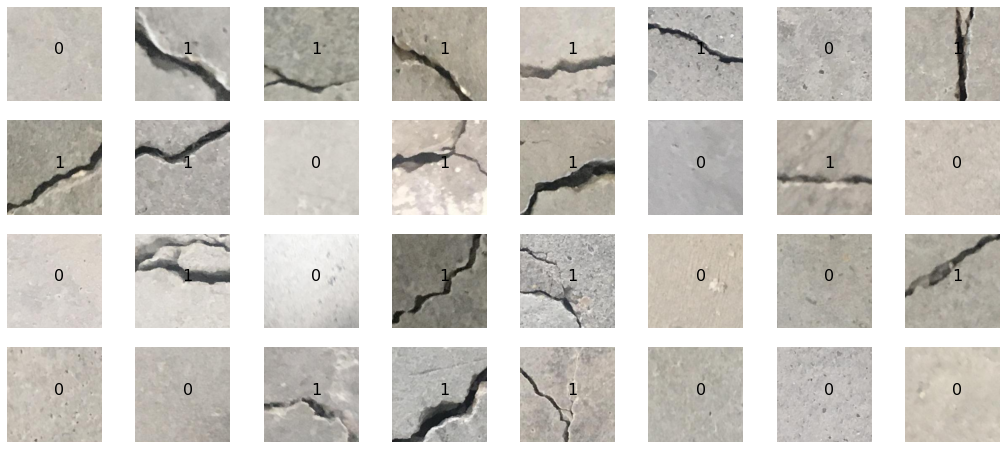

In [13]:
fig, ax = plt.subplots(4,8, figsize=(18,8))
ax = ax.flatten(); [ax.set_axis_off() for ax in ax]

dataiter = iter(train_loader)
images, labels = dataiter.next()

labels = np.array(labels)
images_xyc = list(map(lambda m: np.einsum("CXY->XYC", m), images))

for i, image in enumerate(images_xyc): ax[i].imshow(image)
for i, lab in enumerate(labels): ax[i].text(.5,.5, labels[i], transform=ax[i].transAxes, fontsize=16)

In [14]:
model = CrackClassifier()
model.load_state_dict(torch.load(f"models/crack_binary_c_xx.torch"))
model.eval()

_, predicted = torch.max(model(images), 1)
predicted = np.array(predicted).flatten()

print("Label\t:", labels, sum(labels))
print("Predict\t:", predicted, sum(predicted))

correct_cnt = sum([1 if labels[i]==pred else 0 for i, pred in enumerate(predicted)])
print("Accuracy:", correct_cnt/len(labels)*100, "%\n")

Label	: [0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0] 18
Predict	: [0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0] 18
Accuracy: 93.75 %



In [14]:
for epoch in range(337, 345):
    print(f"Testing epoch{epoch+0:02}")
    model = CrackClassifier()
    model.load_state_dict(torch.load(f"models/crack_binary_c_{epoch+0:02}.torch"))
    model.eval()
    
    _, predicted = torch.max(model(images), 1)
    predicted = np.array(predicted).flatten()
    
    print("Label\t:", labels, sum(labels))
    print("Predict\t:", predicted, sum(predicted))
    
    correct_cnt = sum([1 if labels[i]==pred else 0 for i, pred in enumerate(predicted)])
    print("Accuracy:", correct_cnt/len(labels)*100, "%\n")

print("Done!")

Testing epoch337
Label	: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1] 14
Predict	: [0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
Accuracy: 68.75 %

Testing epoch338
Label	: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1] 14
Predict	: [0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
Accuracy: 68.75 %

Testing epoch339
Label	: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1] 14
Predict	: [0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
Accuracy: 68.75 %

Testing epoch340
Label	: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1] 14
Predict	: [0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 4
Accuracy: 68.75 %

Testing epoch341
Label	: [0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1] 14
Predict	: [0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 5
Accuracy: 71.875 %

Testing epoch342
Label	: [0 0 0 0 1 0 0 1 1 

# Append training